## Stockmarket analysis with `pmdarima`

This example follows the post on [Towards Data Science](https://towardsdatascience.com/stock-market-analysis-using-arima-8731ded2447a) (TDS), demonstrating the use of `pmdarima` to simplify time series analysis.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import pmdarima as pm
print(f"Using pmdarima {pm.__version__}")

Using pmdarima 2.0.4


### Import the data

`pmdarima` contains an embedded `datasets` submodule that allows us to try out models on common datasets. We can load the MSFT stock data from `pmdarima` 1.3.0+:

In [85]:
#from pmdarima.datasets.stocks import load_msft

df = pd.read_csv(r'https://raw.githubusercontent.com/lucas-souza-s/Commodities-e-previsao-de-series-temporais/main/db_soja_modificado/db_pr%C3%A9_processado_dolar.csv',
                              encoding='utf8',
                              delimiter=',',
                              parse_dates=True,
                              index_col=0,
                              verbose=True)

df

C:\Users\Lucas S\AppData\Local\Temp\ipykernel_19512\3907512089.py:3: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  df = pd.read_csv(r'https://raw.githubusercontent.com/lucas-souza-s/Commodities-e-previsao-de-series-temporais/main/db_soja_modificado/db_pr%C3%A9_processado_dolar.csv',


Tokenization took: 23.93 ms
Type conversion took: 14.01 ms
Parser memory cleanup took: 0.00 ms


,preco,residuos,tendencia,sazonalidade,diff_1,diff_2,diff_3,diff_4,diff_5
data,,,,,,,,,
2006-04-17,12.77,-0.041693,12.766333,-0.007283,0.06,0.11,0.17,0.23,0.23
2006-04-18,12.88,-0.089374,12.790000,-0.007207,0.11,0.17,0.22,0.28,0.34
2006-04-19,12.82,-0.263051,12.817667,-0.011955,-0.06,0.05,0.11,0.16,0.22
2006-04-20,12.75,-0.251368,12.851500,-0.038478,-0.07,-0.13,-0.02,0.04,0.09
2006-04-21,12.80,-0.131594,12.882667,-0.038412,0.05,-0.02,-0.08,0.03,0.09
...,...,...,...,...,...,...,...,...,...
2023-12-09,29.76,-0.130305,29.722667,-0.022104,0.01,0.18,0.32,0.43,0.46
2023-12-10,29.76,-0.197523,29.740333,0.007040,0.00,0.01,0.18,0.32,0.43
2023-12-11,29.77,-0.259429,29.757167,0.005083,0.01,0.01,0.02,0.19,0.33


<Axes: xlabel='data'>

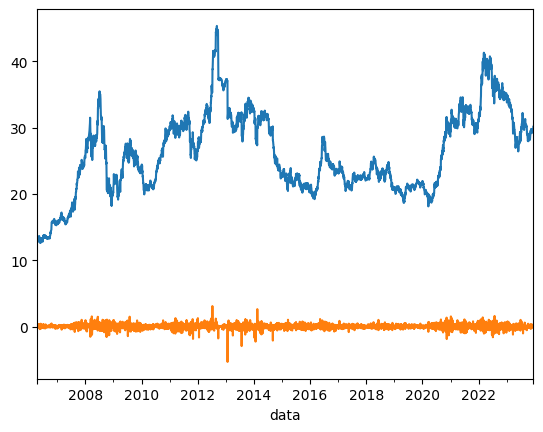

In [86]:
df['preco'].plot()
df['diff_1'].plot()

### Split the data

As in the blog post, we'll use 80% of the samples as training data. Note that a time series' train/test split is different from that of a dataset without temporality; order *must* be preserved if we hope to discover any notable trends.

In [87]:
train_len = int(df.shape[0] * 0.8)
train_data, test_data = df[:train_len], df[train_len:]

y_train = train_data['diff_1'].values
y_test = test_data['diff_1'].values

print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")

5160 train samples
1290 test samples


<Axes: xlabel='data'>

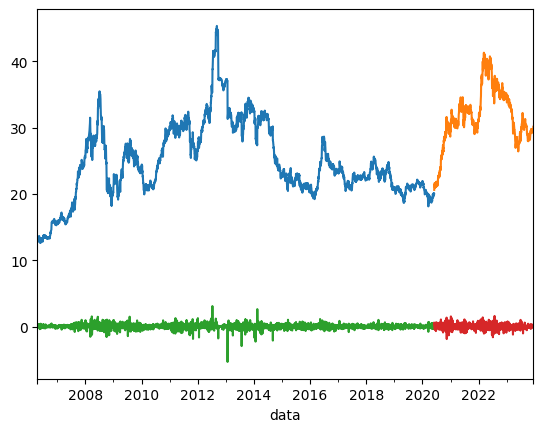

In [91]:
train_data['preco'].plot()
test_data['preco'].plot()
train_data['diff_1'].plot()
test_data['diff_1'].plot()

### Pre-modeling analysis

TDS fixed ``p`` at 5 based on some lag plot analysis:

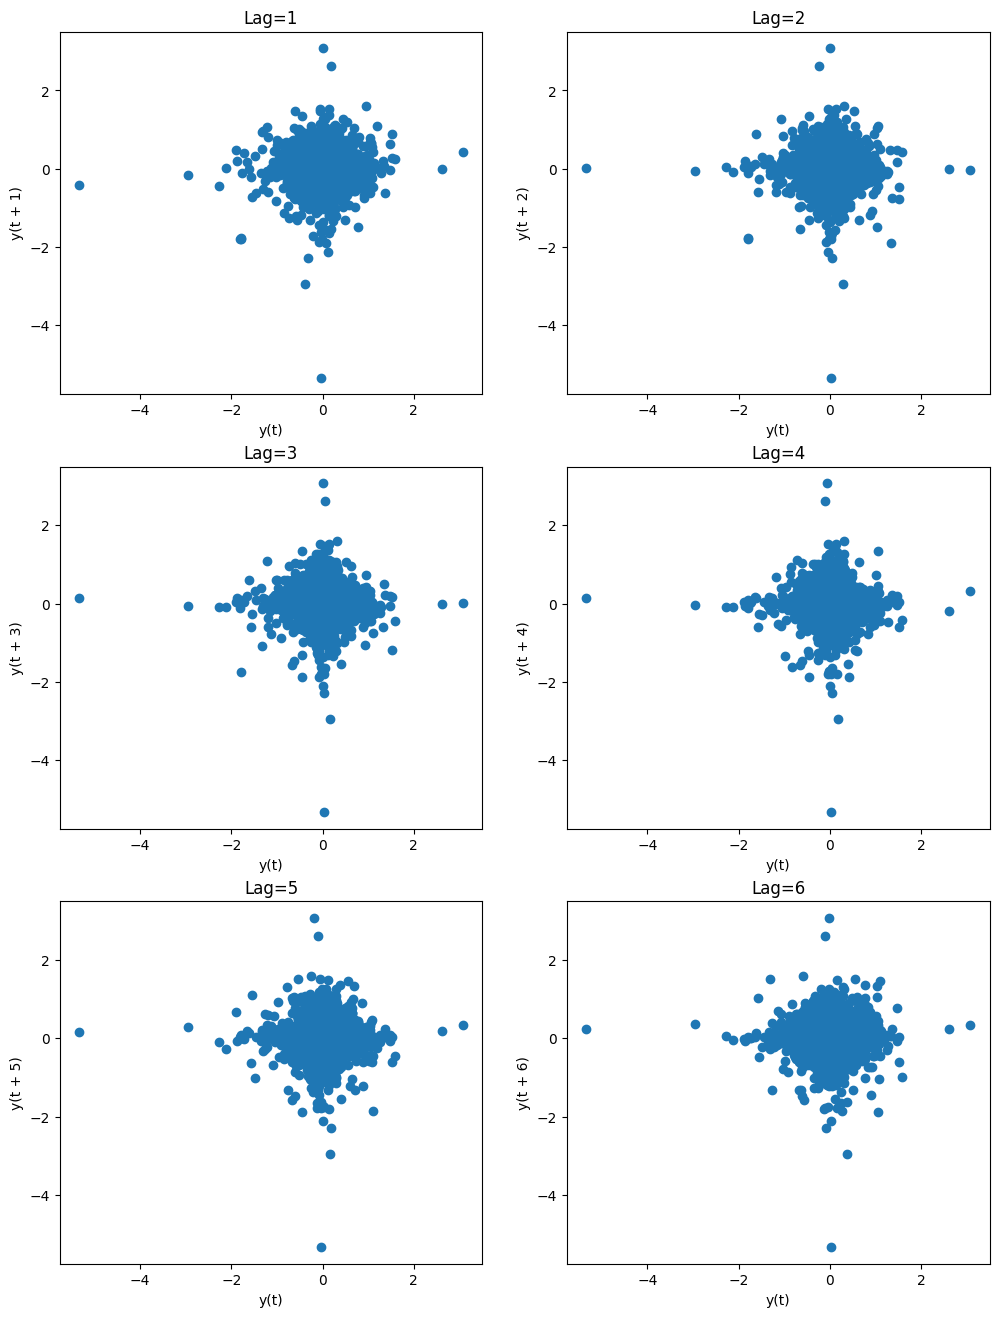

In [5]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(12, 16))
plt.title('MSFT Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df['diff_1'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")
    
plt.show()

All lags look fairly linear, so it's a good indicator that an auto-regressive model is a good choice. Therefore, we'll allow the `auto_arima` to select the lag term for us, up to 6.

### Estimating the differencing term

We can estimate the best lag term with several statistical tests:

In [6]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 0


Use `auto_arima` to fit a model on the data.

In [7]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1579.636, Time=2.58 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1616.918, Time=0.53 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1584.573, Time=0.93 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1587.238, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1579.625, Time=1.35 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1577.914, Time=0.52 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1579.415, Time=0.76 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1581.924, Time=0.78 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1580.996, Time=2.35 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1579.811, Time=1.22 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 11.420 seconds


In [8]:
print(auto.order)

(0, 0, 2)


In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [10]:
model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    
    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
    


In [11]:
mse = mean_squared_error(y_test, forecasts)
mape = mean_absolute_percentage_error(y_test, forecasts)

print(f"MSE: {mean_squared_error(y_test, forecasts):.4f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, forecasts):.4f}%")

MSE: 0.1129
MAPE: 965379180243.7686%


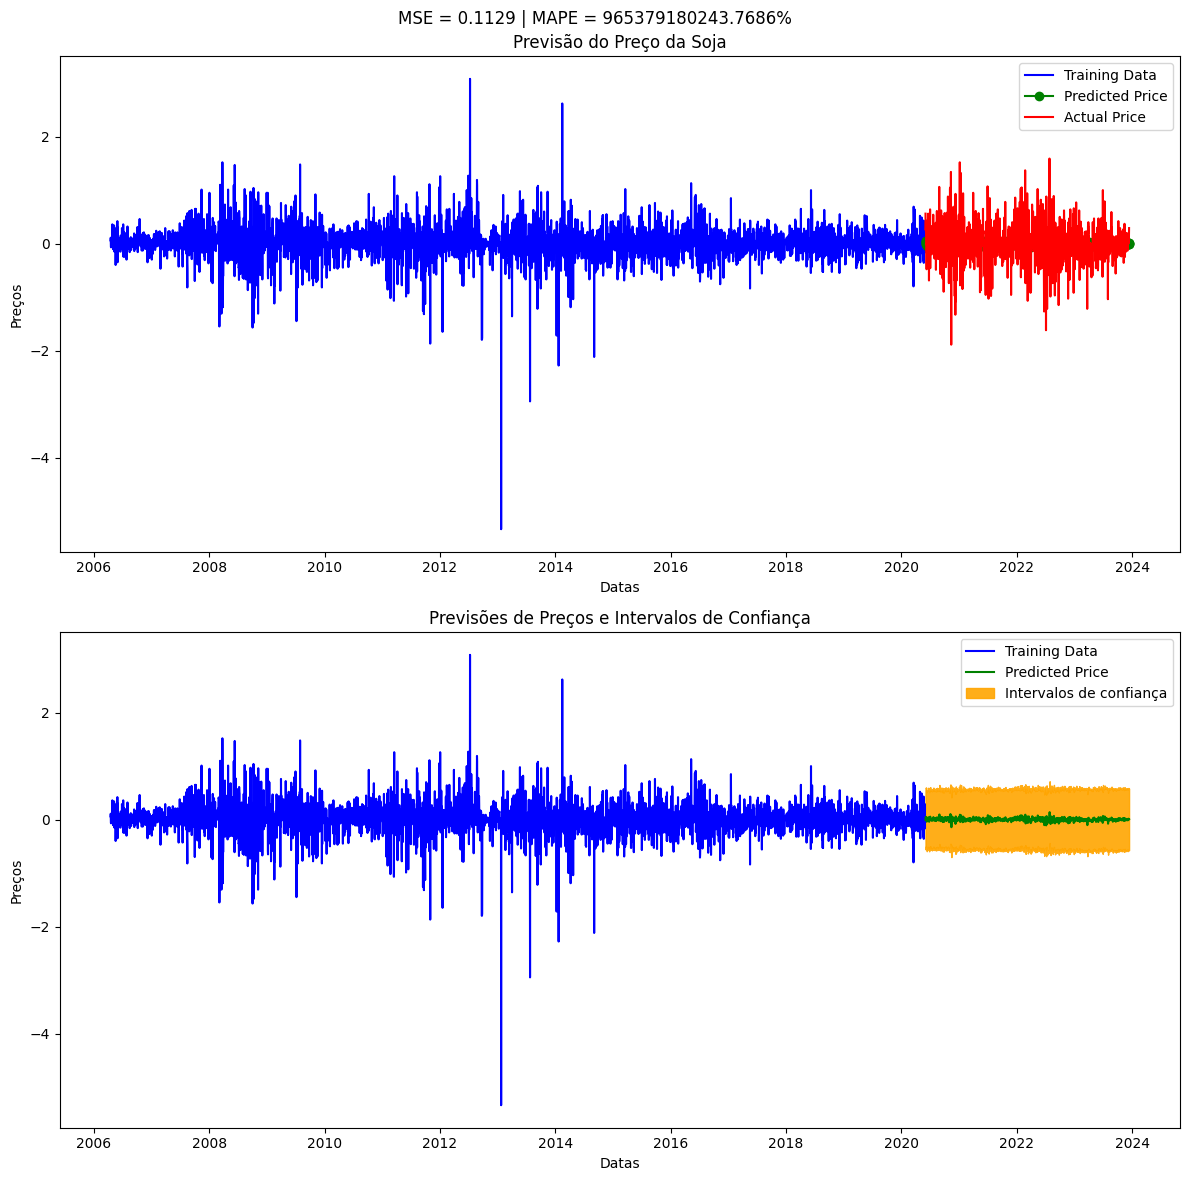

In [92]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(train_data.index, y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o', label='Predicted Price')
axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('Previsão do Preço da Soja')
axes[0].set_xlabel('Datas')
axes[0].set_ylabel('Preços')
axes[0].legend()

# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(train_data.index, y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green', label='Predicted Price')
axes[1].set_title('Previsões de Preços e Intervalos de Confiança')
axes[1].set_xlabel('Datas')
axes[1].set_ylabel('Preços')
conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Intervalos de confiança")
axes[1].legend()

fig.suptitle(f'MSE = {mse:.4f} | MAPE = {mape:.4f}%')
plt.tight_layout()
plt.show()

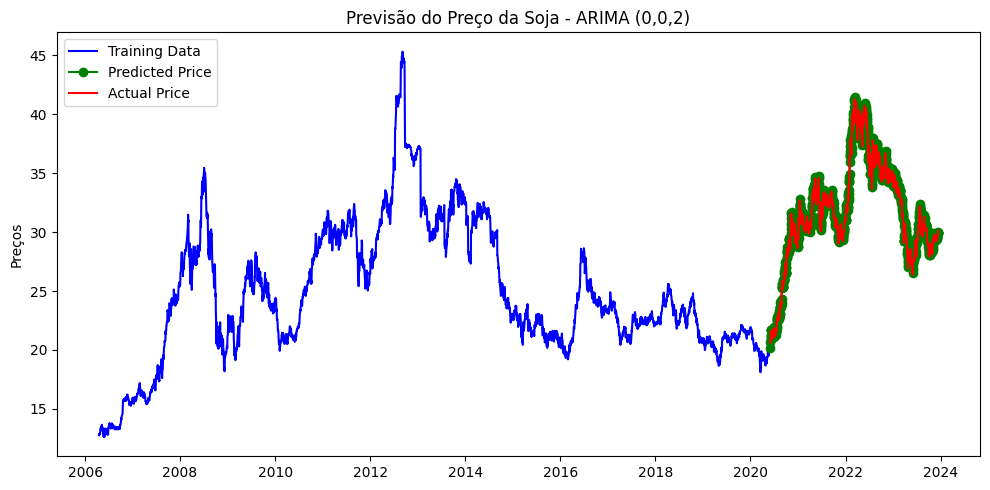

In [126]:
df['PRED'] = df['preco'].shift(1) * (1 + fc)

fig, ax = plt.subplots(figsize=(10, 5))

# --------------------- Actual vs. Predicted --------------------------
ax.plot(train_data.index, train_data['preco'], color='blue', label='Training Data')
ax.plot(test_data.index, df.loc[test_data.index, 'PRED'], color='green', marker='o', label='Predicted Price')
ax.plot(test_data.index, test_data['preco'], color='red', label='Actual Price')
ax.set_title('Previsão do Preço da Soja - ARIMA (0,0,2)')
ax.set_ylabel('Preços')
ax.legend()

plt.tight_layout()
plt.show()